In [3]:
import numpy as np
from math import cos, sin
import sys
from PIL import Image, ImageDraw, ImageColor
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker

In [4]:
from util_functions import wireIntegrate, cutoffPercentile, toGreyScale, createXYGrid, createXZGrid, createXYZGrid

In [5]:
meshsize = 100  # The size of the mesh grid
I = 1 # 1 amp of current flowing through coil
mu0 = 4 *np.pi*10**(-7)  # magnetic permeability constant
radius = 1  # radius of coil in meters
#bbox = (-.05,-.05, -.05, .05, .05, .05)  # bounding box of visual area in meters
bbox = (0,0, 10, 10)  # bounding box of visual area in meters
xgrid, zgrid, vecs = createXZGrid(bbox, meshsize)
print(vecs.shape)

(100, 100, 3)


bbox = (-.05,-.05, -0.05, .05, .05, 0.05)  # bounding box of visual area in meters
xgrid,ygrid,zgrid,vecs = createXYZGrid(bbox, meshsize)
print(xgrid.shape,vecs.shape)

In [6]:
angnum = 360  # The number of evenly spaced angle values around a circumference of length 2*pi*R or part thereof


angles = np.linspace(0, np.pi/2, angnum, endpoint=False)

# create an array of the vector l
coss = np.cos(angles)
sins = np.sin(angles)
zz = np.zeros_like(angles)
l = np.stack((coss, sins, zz), axis=-1)*radius
print (l.shape)

(360, 3)


In [7]:
%time bField = I*wireIntegrate(vecs, l, closed=False)  # Integrate the field around the wire
      
# Now we are only interested in the magnitude of the integral result rather
# than it's direction.





CPU times: user 651 ms, sys: 0 ns, total: 651 ms
Wall time: 653 ms


In [8]:
with open("bField-{}x{}.npy".format(meshsize, meshsize),"wb") as f:
    np.save(f, bField)

In [9]:
with open("bField-{}x{}.npy".format(meshsize, meshsize),"rb") as f:
    bField = np.load(f)

In [10]:
print (bField.shape)

print (bField.ndim)

(100, 100, 3)
3


In [11]:
doubleShape = tuple( x*2 for x in bField.shape[: - 1]) + (bField.shape[-1],)
cellsCanvas = np.zeros(doubleShape)
cellsCanvas.shape

(200, 200, 3)

In [12]:
cellsCanvas[meshsize:2*meshsize, meshsize:2*meshsize] += bField
cellsCanvas[meshsize-1::-1, meshsize:2*meshsize] += bField
cellsCanvas[meshsize-1::-1, meshsize-1::-1] += bField
cellsCanvas[meshsize:2*meshsize, meshsize-1::-1] += bField


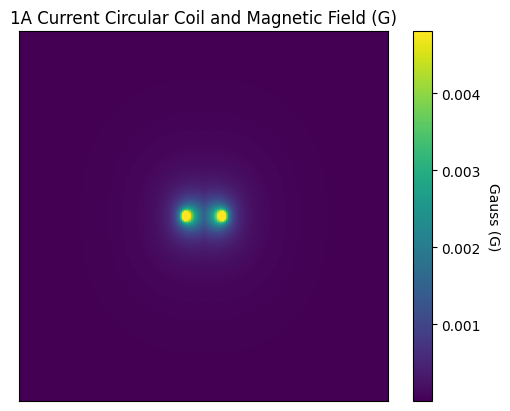

In [13]:
magnitudes = np.linalg.norm( cellsCanvas * mu0/(4*np.pi), axis=-1)
mags = cutoffPercentile(magnitudes, 99.9)

fig,ax = plt.subplots()
plt.title("1A Current Circular Coil and Magnetic Field (G)")

ax.xaxis.set_major_locator(ticker.NullLocator())
ax.yaxis.set_major_locator(ticker.NullLocator())

im = ax.imshow(mags*10000)  # Convert to Gauss units
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Gauss (G)", rotation=-90, va="bottom")

plt.show()


In [14]:
bField.shape

(100, 100, 3)

In [15]:
vs = [ y for y in bField[0,2:4] ]
print (vs)

[array([0.       , 0.       , 2.0286698], dtype=float32), array([0.       , 0.       , 2.3175063], dtype=float32)]


In [16]:
paired_arrays = [np.array([x, y]) for x, y in zip(*vs)]
print (paired_arrays)

[array([0., 0.], dtype=float32), array([0., 0.], dtype=float32), array([2.0286698, 2.3175063], dtype=float32)]


In [17]:
[np.interp(2.5,[2,3], vs) for vs in paired_arrays]

[0.0, 0.0, 2.1730880737304688]

In [18]:
def createCanvasViaRotation(numCells, shape):
    cellCanvas2 = np.zeros(newShape)
    for ii in range(0,numCells):
        for kk in range(0, numCells):
            for jj in range(0, numCells):
                d = np.sqrt(ii**2 + jj**2)
                if int(d) >= numCells: break
                if d == int(d):
                    cellCanvas2[ii, jj, kk] = bField[kk,int(d)]
                else:
                    #print (ii, ' ',jj,' ', end='')
                    xp = [ jj, jj+1 ]
                    if d < bField.shape[1]-1:
                        yps0 = [ y for y in bField[kk,int(d):int(d)+2] ]
                        yps1 = [np.array([x, y]) for x, y in zip(*yps0)]
                        #print (yps1)
                        cellCanvas2[ii,jj, kk] = [np.interp(d,[int(d),int(d)+1], yps0) for vs in yps1]
        
                        #print ("np.interp( {:2f}, {}, {})".format(d, xp , yps1[2]))
                        #print (cellCanvas2[ii,jj])
    return cellCanvas2        

In [19]:
newShape = (bField.shape[0],)*3  + (3,)
%time cellCanvas2 = createCanvasViaRotation(meshsize, newShape)

ValueError: object too deep for desired array

In [19]:
with open("cellCanvas-{}x{}.npy".format(meshsize, meshsize),"wb") as f:
    np.save(f, cellCanvas2)

In [18]:
with open("cellCanvas-{}x{}.npy".format(meshsize, meshsize),"rb") as f:
    cellCanvas2 = np.load(f)

In [19]:
%time magnitudes = np.linalg.norm( cellCanvas2 * mu0/(4*np.pi), axis=-1)

CPU times: user 461 ms, sys: 946 ms, total: 1.41 s
Wall time: 1.41 s


In [20]:
magnitudes[:,:,0].shape

(200, 200)

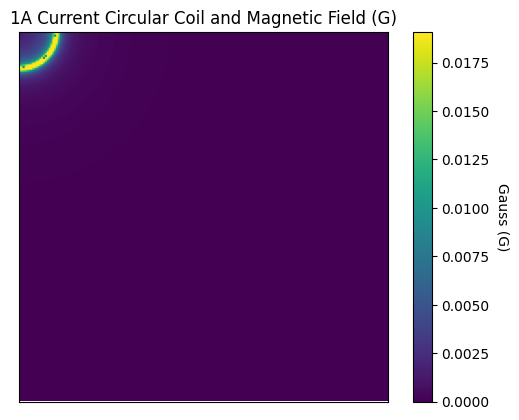

In [21]:
mags = cutoffPercentile(magnitudes, 99.999)

fig,ax = plt.subplots()
plt.title("1A Current Circular Coil and Magnetic Field (G)")

ax.xaxis.set_major_locator(ticker.NullLocator())
ax.yaxis.set_major_locator(ticker.NullLocator())

im = ax.imshow(mags[:,:,0]*10000)  # Convert to Gauss units
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Gauss (G)", rotation=-90, va="bottom")

plt.show()

In [22]:
bField = cellCanvas2

In [23]:
doubleShape = tuple( x*2 for x in bField.shape[: - 1]) + (bField.shape[-1],)
cellsCanvas = np.zeros(doubleShape)
print (cellsCanvas.shape)
print (bField.shape)

(400, 400, 400, 3)
(200, 200, 200, 3)


In [ ]:
cellsCanvas[meshsize:2*meshsize, meshsize:2*meshsize, meshsize:2*meshsize] = bField
cellsCanvas[meshsize-1::-1, meshsize:2*meshsize,meshsize:2*meshsize] = bField
cellsCanvas[meshsize-1::-1, meshsize-1::-1, meshsize:2*meshsize] = bField
cellsCanvas[meshsize:2*meshsize, meshsize-1::-1, meshsize:2*meshsize] = bField

In [ ]:
%time magnitudes = np.linalg.norm( cellsCanvas * mu0/(4*np.pi), axis=-1)

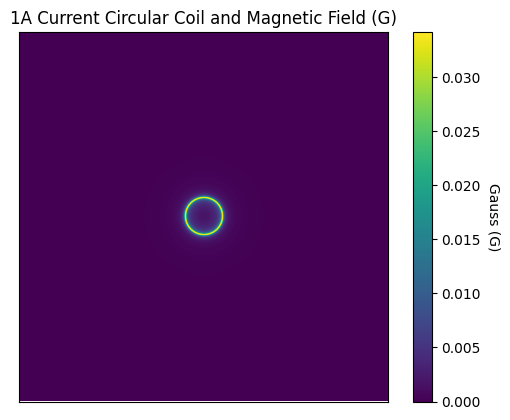

In [40]:
mags = cutoffPercentile(magnitudes, 99.9)

fig,ax = plt.subplots()
plt.title("1A Current Circular Coil and Magnetic Field (G)")

ax.xaxis.set_major_locator(ticker.NullLocator())
ax.yaxis.set_major_locator(ticker.NullLocator())

im = ax.imshow(mags*10000)  # Convert to Gauss units
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Gauss (G)", rotation=-90, va="bottom")

plt.show()